In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

%matplotlib inline


In [53]:
df = pd.read_csv('data.csv', parse_dates=['timestamp'])
print("Data shape:", df.shape)
display(df.head())
df.info()


Data shape: (16857, 29)


,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     16857 non-null  datetime64[ns]
 1   equipment_energy_consumption  16013 non-null  object        
 2   lighting_energy               16048 non-null  object        
 3   zone1_temperature             15990 non-null  object        
 4   zone1_humidity                16056 non-null  object        
 5   zone2_temperature             16004 non-null  object        
 6   zone2_humidity                15990 non-null  float64       
 7   zone3_temperature             16055 non-null  float64       
 8   zone3_humidity                15979 non-null  float64       
 9   zone4_temperature             16041 non-null  float64       
 10  zone4_humidity                16076 non-null  float64       
 11  zone5_temperature           

In [54]:
# Convert target to numeric and drop missing
df['equipment_energy_consumption'] = pd.to_numeric(df['equipment_energy_consumption'], errors='coerce')
df = df.dropna(subset=['equipment_energy_consumption'])

# Fill missing values for numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


In [55]:
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df = df.drop('timestamp', axis=1)


In [56]:
X_all = df.drop('equipment_energy_consumption', axis=1).apply(pd.to_numeric, errors='coerce')
X_all.fillna(X_all.mean(), inplace=True)
y_all = df['equipment_energy_consumption']


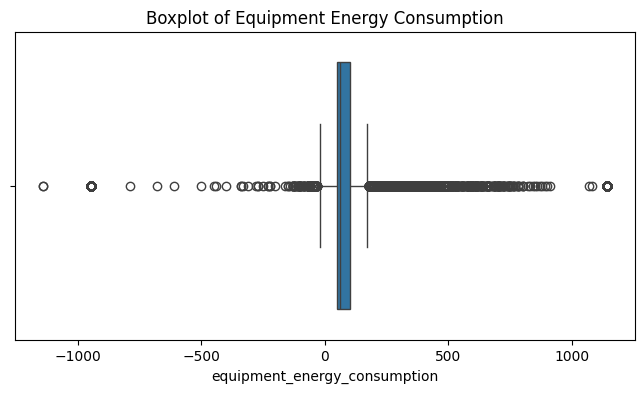

Shape after outlier removal: (13762, 29)


In [57]:
plt.figure(figsize=(8,4))
sns.boxplot(x=y_all)
plt.title('Boxplot of Equipment Energy Consumption')
plt.show()

# Remove outliers beyond 1.5*IQR
Q1 = y_all.quantile(0.25)
Q3 = y_all.quantile(0.75)
IQR = Q3 - Q1
mask = (y_all >= Q1 - 1.5*IQR) & (y_all <= Q3 + 1.5*IQR)

X_all_no_out = X_all[mask]
y_all_no_out = y_all[mask]
print(f"Shape after outlier removal: {X_all_no_out.shape}")


In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all_no_out, y_all_no_out, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [59]:
xgb = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)


XGBoost RMSE: 17.998
XGBoost MAE: 12.883
XGBoost R²: 0.610


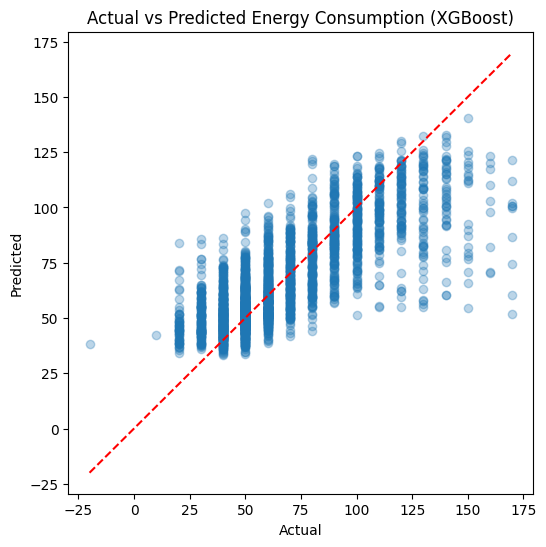

In [60]:
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.3f}")
print(f"XGBoost MAE: {mean_absolute_error(y_test, y_pred_xgb):.3f}")
print(f"XGBoost R²: {r2_score(y_test, y_pred_xgb):.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Energy Consumption (XGBoost)')
plt.show()


In [61]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Cross-validated R²: {scores.mean():.3f} ± {scores.std():.3f}")


Cross-validated R²: 0.580 ± 0.013
